![](https://papimaxblog.files.wordpress.com/2016/11/hello_world_blog_post.png?w=816)

# Introduction

As data analysts all of us probably faced this type of issue: how does the insights I found reflect the field reality ? Is the analysis/modelling method I used "correct" ? For those who don't have this concern, I created this notebook to show how the answer to even a simple business question can be strongly biased by the method chosen during the analysis. 

To illustrate this problematic, I chose to work with LEGO data, because LEGOs are the coolest thing on Earth. The business question we will try to answer is: "**Which color tints are the most used to create sets ?**". This notebook uses a LEGO database I found on [Rebrickable website](http://rebrickable.com/downloads/) which regroup information on every LEGO set (inventory, creative universe, year...) and part (category, color...). The database is structured as follows:

![Rebrickable database structure (source: rebrickable.com)](https://rebrickable.com/static/img/diagrams/downloads_schema_v3.png)

To answer this simple business question we will first classify colors into tints then identify which tint is the most represented within LEGO parts and sets. Let's go!

In [21]:
# Import libraries used for this notebook

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# 1. Importing and exploring color data

The overall goal of exploring Lego colors is to classify them into different color tints. The chosen tints are the primary colors (red, green and blue for additive synthesis; cyan, magenta and yellow for substractive synthesis) and are stored with their RGB values in the "colors_categories" CSV file.

A tint classification reference file was also created, stored in the "manual_categories" CSV file. This reference will be used to compare with the method used later in this notebook to classify colors into color tints.

First preprocessing steps consist in merging the Lego color dataset with the classification reference table, drop Gray color tints and non-used columns.

In [22]:
# Import CSV files and cleaning color data

colors = pd.read_csv('static_inputs/colors.csv')
# color table from rebrickable database
colcat = pd.read_csv('static_inputs/colors_categories.csv', sep=';')
# manual table of color categories and their RGB values
mancat = pd.read_csv('static_inputs/manual_categories.csv', sep=';')
# manual table of rebrickable Lego colors with a manual classification I made

colcat = colcat[colcat['Category'].isin(['Red', 'Blue', 'Green', 'Magenta', 'Yellow', 'Cyan'])]
colors = pd.merge(colors, mancat, on='name')
grays = colors[colors['category'] == 'Gray'].reset_index(drop=True).drop(columns=['is_trans'])
colors = colors[colors['category'] != 'Gray'].reset_index(drop=True).drop(columns=['is_trans'])

print(colors.info())
colors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        137 non-null    int64 
 1   name      137 non-null    object
 2   rgb       137 non-null    object
 3   category  137 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.4+ KB
None


,id,name,rgb,category
0,1,Blue,0055BF,Blue
1,2,Green,237841,Green
2,3,Dark Turquoise,008F9B,Cyan
3,4,Red,C91A09,Red
4,5,Dark Pink,C870A0,Magenta


Then the colors RGB components are extracted and converted to integers to be used in data exploration then in classification methods.

In [23]:
def extract_rgb(df, col_rgb, col_name, pos):
    """Extract R, G and B componenets of RGB hex code and convert to integer."""
    df[col_name] = df[col_rgb].str[pos:pos+2]
    df[col_name] = [int(n, 16) for n in df[col_name]]
    df[col_name] = df[col_name].astype('int64')
    
extract_rgb(colors, 'rgb', 'r', 0)
extract_rgb(colors, 'rgb', 'g', 2)
extract_rgb(colors, 'rgb', 'b', 4)

extract_rgb(grays, 'rgb', 'r', 0)
extract_rgb(grays, 'rgb', 'g', 2)
extract_rgb(grays, 'rgb', 'b', 4)

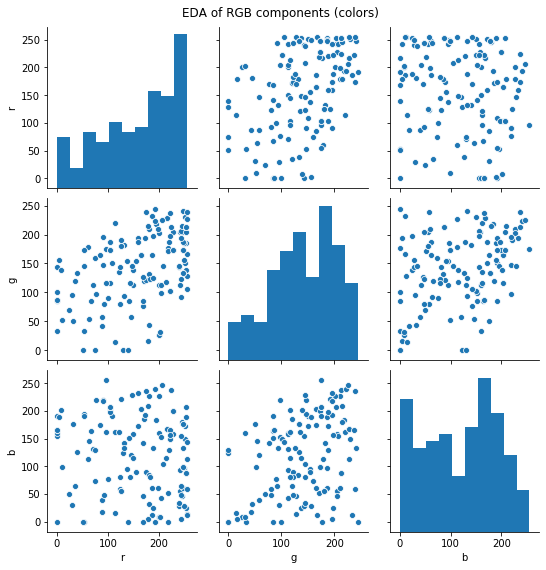

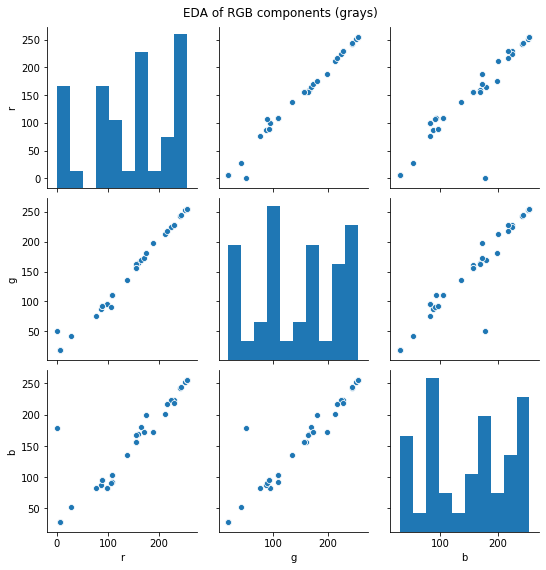

In [24]:
g0 = sns.pairplot(colors[['r', 'g', 'b']])
g0.fig.suptitle('EDA of RGB components (colors)', y=1.03)
plt.show()

g1 = sns.pairplot(grays[['r', 'g', 'b']])
g1.fig.suptitle('EDA of RGB components (grays)', y=1.03)
plt.show()

Through the scatterplots above we observe that there is no clear relationship or cluster in the colors RGB components. On the other hand there is a clear linear relationship between these components for grayscale colors as they have approximately equals R, G and B component values : black is (0;0;0), white is (255;255;255).

# 2. Colors Classification

To classify the colors into the six color tints we defined at the beginning, some conversions from the RGB color encoding to other color classification systems are tried.
The colors are converted into three 3-dimensional color spaces (RGB, CIE XYZ and CIE Lab, through functions inspired from [OpenCV library](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor)) and three 2-dimensional spaces (related to [this french Wikipedia article on chromaticity diagrams](https://fr.wikipedia.org/wiki/Diagramme_de_chromaticit%C3%A9)). The colors are then associated to the nearest color tint regarding linear distance.

In [25]:
## Some useful functions to classify colors (color space conversion functions mainly)

def f(t):
    """Function used for RGB -> CIE Lab conversion."""
    if t > ((6 / 29) ** 3):
        return (t ** (1 / 3))
    else:
        return (1 / 3)*((29 / 6) ** 2) * t + (4 / 29)

def rgb_XYZ(r, g, b):
    """Return list of X, Y and Z values in CIE XYZ color space from RGB integer components."""
    rgb = np.array([[r/255],
                   [g/255],
                   [b/255]])
    mat = np.array([[0.412453, 0.357580, 0.180423],
                   [0.212671, 0.715160, 0.072169],
                   [0.019334, 0.119193, 0.950227]])
    xyz = np.dot(mat, rgb)
    return [xyz[0], xyz[1], xyz[2]]

def XYZ_Lab(XYZ):
    """Return list of L, a and b values in CIE Lab color space from [X, Y, Z] components as a list."""
    X = XYZ[0]
    Y = XYZ[1]
    Z = XYZ[2]
    L = 116 * f(Y) - 16
    a = 500 * (f(X / 0.950456) - f(Y))
    b = 200 * (f(Y) - f(Z / 1.088754))
    return [L, a, b]

def rgb_rg(r, g, b):
    """Return r and g coordinates from CIE (r, g) color diagram based on RGB components."""
    return [r/(r+g+b), g/(r+g+b)]

def XYZ_xy(XYZ):
    """Return x and y coordinates from CIE (x, y) color diagram based on CIE XYZ components as a list."""
    X = XYZ[0]
    Y = XYZ[1]
    Z = XYZ[2]
    return [X/(X+Y+Z), Y/(X+Y+Z)]

def xy_uv(xy):
    """Return u' and v' coordinates from CIE (u', v') color diagram based on CIE (x, y) coordinates."""
    x = xy[0]
    y = xy[1]
    return [4*x/(-2*x+12*y+3), 9*y/(-2*x+12*y+3)]

def generate_cie(df):
    """Generate many CIE color space/diagram coordinates from a DataFrame which contains RGB components columns."""
    df['XYZ'] = [rgb_XYZ(r, g, b) for r, g, b in zip(df['r'], df['g'], df['b'])]
    df['Lab'] = [XYZ_Lab(XYZ) for XYZ in df['XYZ']]
    df['rg'] = [rgb_rg(r, g, b) for r, g, b in zip(df['r'], df['g'], df['b'])]
    df['xy'] = [XYZ_xy(XYZ) for XYZ in df['XYZ']]
    df['uv'] = [xy_uv(xy) for xy in df['xy']]
    df['RGB'] = [[r, g, b] for r, g, b in zip(df['r'], df['g'], df['b'])]
    return df

def categorize_color(color, refs, col):
    """Link a color to its nearest color tint based on linear distance between coordinates on specified space.
    color: DataFrame of colors to link to a tint.
    refs: DataFrame of tint colors containing a 'Category' column.
    col: color space on which the link is made."""
    min = 999
    for i in refs.index:
        dist = np.linalg.norm(np.array(color)-np.array(refs.loc[i, col]))
        if dist < min:
            min = dist
            cat = refs.loc[i, 'Category']
    return cat

def cat_color_name(clist, name):
    """Return the name contained in clist if contained in name list, else return None."""
    for col in clist:
        if col in name:
            return col
    return None

In [26]:
## Colors processing, generating multiple color space coordinates

colors = generate_cie(colors)
colcat = generate_cie(colcat)

colors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        137 non-null    int64 
 1   name      137 non-null    object
 2   rgb       137 non-null    object
 3   category  137 non-null    object
 4   r         137 non-null    int64 
 5   g         137 non-null    int64 
 6   b         137 non-null    int64 
 7   XYZ       137 non-null    object
 8   Lab       137 non-null    object
 9   rg        137 non-null    object
 10  xy        137 non-null    object
 11  uv        137 non-null    object
 12  RGB       137 non-null    object
dtypes: int64(4), object(9)
memory usage: 14.0+ KB


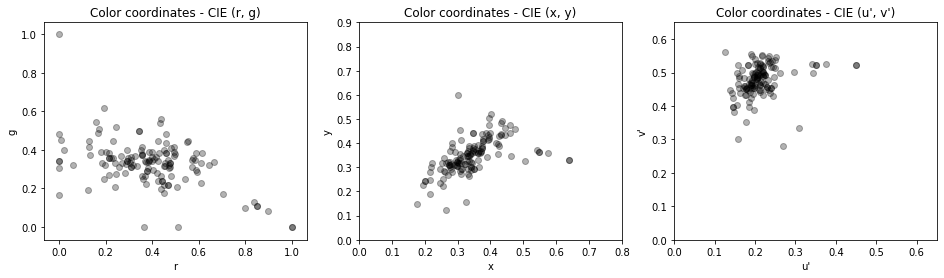

In [27]:
## Visualizing color points in color spaces (r,g), (x,y) and (u', v')

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
for i in range(0, len(colors)):
    plt.scatter(colors['rg'][i][0], colors['rg'][i][1], c='black', alpha=0.3)
plt.title('Color coordinates - CIE (r, g)')
plt.xlabel('r')
plt.ylabel('g')

plt.subplot(1, 3, 2)
for i in range(0, len(colors)):
    plt.scatter(colors['xy'][i][0], colors['xy'][i][1], c='black', alpha=0.3)
plt.xlim(0, 0.8)
plt.ylim(0, 0.9)
plt.title('Color coordinates - CIE (x, y)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 3, 3)
for i in range(0, len(colors)):
    plt.scatter(colors['uv'][i][0], colors['uv'][i][1], c='black', alpha=0.3)
plt.xlim(0, 0.65)
plt.ylim(0, 0.65)
plt.title('Color coordinates - CIE (u\', v\')')
plt.xlabel('u\'')
plt.ylabel('v\'')

plt.show()

![Color diagrams with scatter plots](https://zupimages.net/up/20/42/mdlz.png)

With scatterplot visualizations, we see that most of the color points are centered on a "white" chromaticity zone, which in the chromaticity diagrams is near the cyan and the yellow zones. From this result, we can expect that the color classification through most of the methods based on chromaticity calculation will not get a satisfying result compared to the manual classification baseline.

In [28]:
## Colors classification based on multiple color space coordinates

cols = ['RGB', 'rg', 'xy', 'uv', 'Lab']
for col in cols:
    colors['Cat_' + col] = [categorize_color(color, colcat, col) for color in colors[col]]

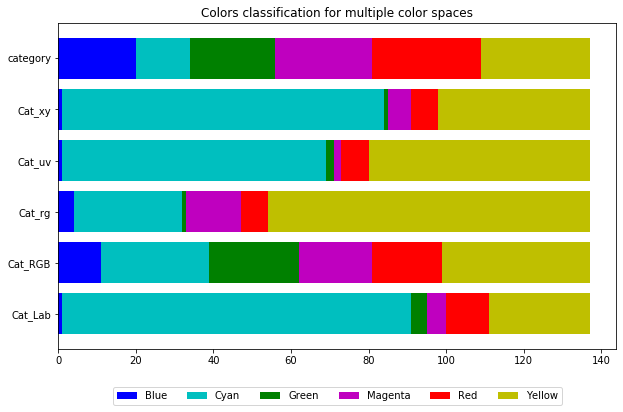

In [29]:
## Visualizing classification differences between used color spaces

colors_rep = pd.melt(colors[['category', 'Cat_RGB', 'Cat_rg', 'Cat_xy', 'Cat_uv', 'Cat_Lab']], var_name='Méthode', value_name='Couleur').pivot_table(index='Méthode', columns='Couleur', values='Couleur', aggfunc=len)
colors_rep_cum = colors_rep.cumsum(axis=1)
plt.figure(figsize=(10, 6))
for col in colors_rep.columns:
    plt.barh(colors_rep.index, colors_rep[col], left=colors_rep_cum[col]-colors_rep[col], color=col[0].lower(), label=col)
plt.title('Colors classification for multiple color spaces')
plt.legend(ncol=len(colors_rep.columns), loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.show()

As expected, the classifications are very different. There is a majority of yellow and turquoise tint attribution, related to the effect seen on the previous scatterplots. The closest color repartition to the color classification baseline (printed as 'category' on the plot) is with the RGB color encoding linear distance calculation.

Finally, a color classification is made based on the color name, looking for if the name contains the name of the color tint.

In [30]:
## Color classification through the color name (being or containing the tint color name)

clist = ['Blue', 'Green', 'Red', 'Turquoise', 'Magenta', 'Yellow']
colors['Cat_Name'] = [cat_color_name(clist, name) for name in colors['name']]
print(colors['Cat_Name'].value_counts())

Blue         26
Green        20
Red          10
Yellow        9
Turquoise     2
Magenta       1
Name: Cat_Name, dtype: int64


# 3. Inventoring parts by color category

Before making the Lego parts inventory, the colors DataFrame has to be cleaned. The classification baseline, the RGB based classification and the name classification are kept for the following processes in order to limit the quantity of different answers to the initial business question : "**Which color tints are the most used to create sets ?**".

To make the Lego inventory counts, inventories, parts and part categories tables are imported from the database. These tables are then merged and the cleaned colors table is joined to create a single dataframe.

In [31]:
## Importing csv files and preprocessing data for parts and sets inventories

colors = colors.drop(columns=['XYZ', 'Lab', 'rg', 'xy', 'uv', 'r', 'g', 'b', 'Cat_rg', 'Cat_xy', 'Cat_uv', 'Cat_Lab'])
inventories = pd.read_csv('static_inputs/inventory_parts.csv')
parts = pd.read_csv('static_inputs/parts.csv')
categories = pd.read_csv('static_inputs/part_categories.csv')

df = pd.merge(inventories, parts[['part_num', 'part_cat_id']], on='part_num')
df = pd.merge(df, categories, left_on='part_cat_id', right_on='id').drop(columns=['id', 'is_spare'])
df = pd.merge(df, colors, left_on='color_id', right_on='id').drop(columns=['id', 'RGB', 'rgb'])
col_name = {'name_x': 'part_cat_name', 'name_y': 'color_name'}
df = df.rename(columns=col_name)
df['Cat_Name'] = df['Cat_Name'].str.replace('Turquoise', 'Cyan')
bricks = df[df['part_cat_name'].str.contains('Bricks')]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364273 entries, 0 to 364272
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   inventory_id   364273 non-null  int64 
 1   part_num       364273 non-null  object
 2   color_id       364273 non-null  int64 
 3   quantity       364273 non-null  int64 
 4   part_cat_id    364273 non-null  int64 
 5   part_cat_name  364273 non-null  object
 6   color_name     364273 non-null  object
 7   category       364273 non-null  object
 8   Cat_RGB        364273 non-null  object
 9   Cat_Name       260782 non-null  object
dtypes: int64(4), object(6)
memory usage: 30.6+ MB
None


The inventory counts are made through two methods :
*     The first method is to count every part color separately without considering how they are grouped in sets.
*     The second method is to qualify the color tint of each set regarding the color of its parts then count the sets colors.

These two methods are transcripted into functions below. They are used to count all the Lego parts (in the df dataframe) and all the Lego bricks (in the bricks dataframe, based on the categories containing "bricks").

In [32]:
## Functions used to make inventory counts 

def count_parts(dfp, col, meth):
    """Return a pivot table DataFrame of parts sum by color tint with a name given to the counting method."""
    df = dfp.pivot_table(index=col, values='quantity', aggfunc=np.sum).reset_index().rename(columns={col:'color'})
    df['method'] = meth
    return df

def count_sets(dfp, col, meth):
    """Return a pivot table DataFrame counting sets color tint. Each set's color tint is established by the most represented color 
    tint in the set's parts. If draw, both the colors are counted."""
    df = dfp.pivot_table(index='inventory_id', columns=col, values='quantity', aggfunc=np.sum).fillna(0).reset_index(drop=True)
    df['max'] = [max(b, c, g, m, r, y) for b, c, g, m, r, y in zip(df['Blue'], df['Cyan'], df['Green'], df['Magenta'], df['Red'], df['Yellow'])]
    dict_df = {'Blue': 0, 'Green': 0, 'Red': 0, 'Yellow': 0, 'Magenta': 0, 'Cyan': 0}
    for i in df.index:
        for c in dict_df.keys():
            if df.loc[i, c] == df.loc[i, 'max']:
                dict_df[c] += 1
    dfr = pd.DataFrame.from_dict(dict_df, orient='index', columns=['quantity']).reset_index().rename(columns={'index':'color'})
    dfr['method'] = meth
    return dfr

In [33]:
## Inventory counts on parts scale based on all parts then all bricks 

synth = count_parts(df, 'category', 'cat_parts_all') \
    .append(count_parts(df, 'Cat_Name', 'name_parts_all'), ignore_index=True) \
    .append(count_parts(df, 'Cat_RGB', 'rgb_parts_all'), ignore_index=True) \
    .append(count_parts(bricks, 'category', 'cat_parts_bri'), ignore_index=True) \
    .append(count_parts(bricks, 'Cat_Name', 'name_parts_bri'), ignore_index=True) \
    .append(count_parts(bricks, 'Cat_RGB', 'rgb_parts_bri'), ignore_index=True)

In [34]:
## Inventory counts on sets (through set classification) based on all parts then all bricks

synth = synth.append(count_sets(df, 'category', 'cat_sets_all'), ignore_index=True) \
    .append(count_sets(df, 'Cat_Name', 'name_sets_all'), ignore_index=True) \
    .append(count_sets(df, 'Cat_RGB', 'rgb_sets_all'), ignore_index=True) \
    .append(count_sets(bricks, 'category', 'cat_sets_bri'), ignore_index=True) \
    .append(count_sets(bricks, 'Cat_Name', 'name_sets_bri'), ignore_index=True) \
    .append(count_sets(bricks, 'Cat_RGB', 'rgb_sets_bri'), ignore_index=True)
synth.head()

,color,quantity,method
0,Blue,206021,cat_parts_all
1,Cyan,34791,cat_parts_all
2,Green,121201,cat_parts_all
3,Magenta,43478,cat_parts_all
4,Red,447783,cat_parts_all


In [35]:
## Normalizing inventory counts and creating a pivot table for visualization

synth['prop'] = [synth.loc[i, 'quantity'] / np.sum(synth.loc[synth['method'] == synth.loc[i, 'method'], 'quantity']) for i in synth.index]
synth = synth.pivot_table(index='color', columns='method', values='prop')
synth

method,cat_parts_all,cat_parts_bri,cat_sets_all,cat_sets_bri,name_parts_all,name_parts_bri,name_sets_all,name_sets_bri,rgb_parts_all,rgb_parts_bri,rgb_sets_all,rgb_sets_bri
color,,,,,,,,,,,,
Blue,0.179211,0.182724,0.165466,0.170580,0.261512,0.243081,0.243128,0.230696,0.150161,0.153674,0.122170,0.143930
Cyan,0.030264,0.018610,0.021348,0.024590,0.004181,0.003217,0.004272,0.005346,0.062907,0.055983,0.049472,0.053794
Green,0.105429,0.104840,0.077008,0.083296,0.124771,0.116843,0.108948,0.108339,0.188840,0.179317,0.176629,0.164697
Magenta,0.037820,0.031550,0.036787,0.042202,0.007189,0.006320,0.008867,0.013305,0.022783,0.017779,0.018893,0.020988
Red,0.389512,0.403178,0.383010,0.445503,0.406429,0.421256,0.349859,0.453077,0.269777,0.282730,0.240881,0.295924
Yellow,0.257765,0.259099,0.316380,0.233828,0.195919,0.209284,0.284925,0.189237,0.305532,0.310518,0.391955,0.320667


# 4. Results

To sum up the different counts, a representation of the six color tints proportions in the Legos is plotted for each methods combination. The goal is to answer the question "**Which color tints are the most used to create sets ?**". Each combination method is named on the following scheme :

"[color classification method] _ [count method] _ [count basis]"

*Color classification methods*: "cat" for the manual color classification baseline, "name" for the classification based on the color name and "rgb" for the classification based on RGB color encoding.

*Count methods*: "parts" for the counting method based on every parts separately, "sets" for the counting method based on the color classification of sets.

*Count basis*: "all" for the use of all parts, "bri" for the use of bricks only.

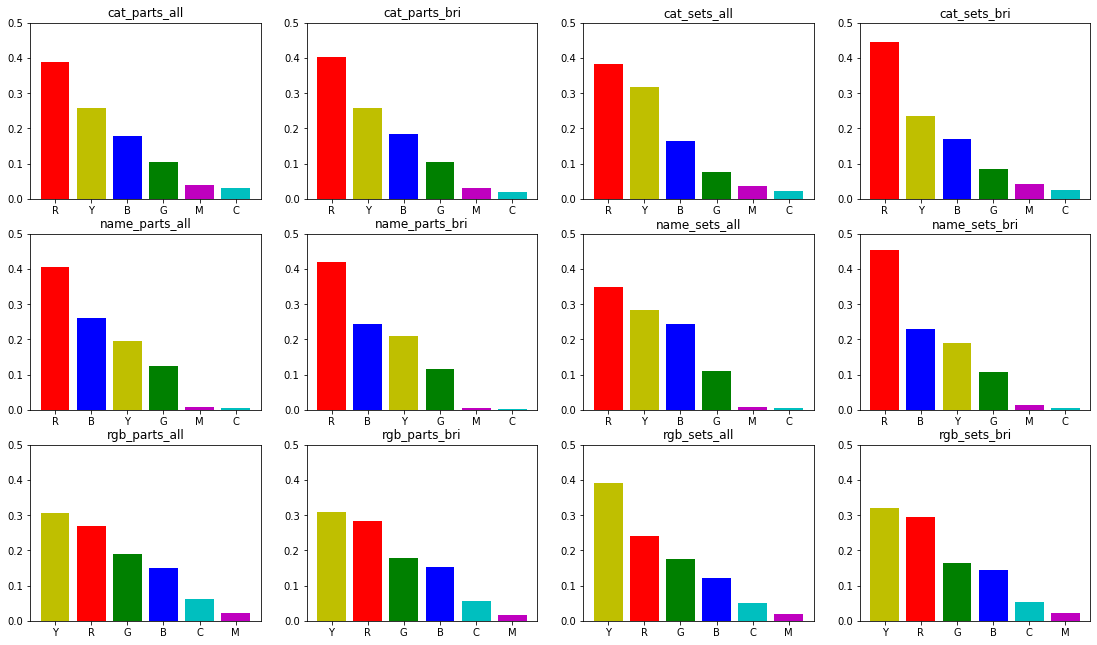

In [36]:
## Visualizing each inventory count with different method used for color classification then inventory counting

i=1
plt.figure(figsize=(19, 11))
for col in synth.columns:
    plt.subplot(3, 4, i)
    synth = synth.sort_values(col, ascending=False)
    plt.bar(synth.index.str[0], synth[col], color=synth.index.str[0])
    plt.ylim(0, 0.5)
    plt.title(col)
    i+=1
plt.show()

The color classification method is the most impacting factor on the results. Within a same color classification method, there is less result differences from a count method/basis to another. Besides the "three most used colors" shown on the plots, there are also differences in the color proportions from a method to another.

# Conclusion

Through this Lego example we observed that a lot of analysis methods can be used to answer a same question. With 12 methods tried (combination of 3 color classification methods, 2 counting methods and 2 counting basis), the results are already very different. Is there any good analysis methodology to answer any business case ? How to ensure the data analysis keeps consistent with the field reality ? 

To me, there are at least 3 important behaviors to keep when analyzing a business case:

1. Have as much knowledge on the job/field reality and needs related to the data used for the business case.
2. Explore the data and validate simple insight hypothesis before going too deep. It also helps to ensure data quality.
3. Make sure your model and analysis are consistent with business client needs (what to include or not, specific criterias...). To do regular touchbases with model explanations is a good way to keep tracks in my opinion.

Thank you for reading this notebook!